In [1]:
import pandas as pd
import scipy
from pandas import read_csv
from pandas import DatetimeIndex
from pandas import datetime
from pandas import Series
from pandas import concat
from pandas import groupby
from pandas import DataFrame
from math import sqrt
from matplotlib import pyplot
import numpy as np
from numpy import concatenate
from natsort import natsorted, ns
import seaborn as sns
import csv
import glob, os
from math import ceil

                 Exp1  Exp2  Exp3  Exp4  Exp5  Mean     M-er     M+er  \
Underprovision     22    21    21    21    21  21.2  20.6447  21.7553   
Great_provision    99    94    97    97   100  97.4  94.5415  100.259   
Overprovision      79    85    82    82    79  81.4  78.2834  84.5166   

                    Error  
Underprovision   0.555289  
Great_provision   2.85853  
Overprovision     3.11655  


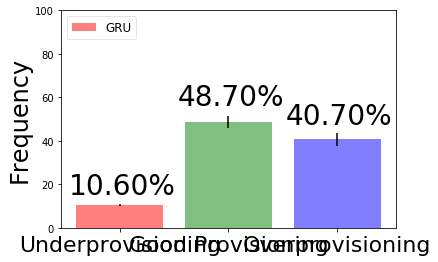

In [4]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    t = scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    h = se * t
    return m, m-h, m+h ,h
def func(bin_avaia, delta,lstm_forecast,capacity_nfv):

    if delta >= 0:
            if bin_avaia >= delta : return ceil(delta/capacity_nfv) 
            else : return 0
    else : 
        avaiability = ((ceil(lstm_forecast%capacity_nfv)*capacity_nfv)-lstm_forecast) % capacity_nfv
        if avaiability >= abs(delta) : return 0
        else : return -(ceil(abs(delta)/capacity_nfv))

def return_count(exp,epo,lag,capacity_nfv):
    exp_number = exp
    epoch = epo
    n_lag = lag
    
    filename = "arima_forecast_N%d_Lg%d.csv"%(exp_number,n_lag)


    series = DataFrame()
    series = read_csv('Result/Eval/'+filename, header=0, index_col='date_time', sep='\t',squeeze=True)
    ground_trut =read_csv('Result/test_prediction.csv', header=0, index_col='date_time', sep='\t',squeeze=True)
    idxa = series.index

    arima_series = DataFrame(columns=['ARIMA'],index=idxa)
    s = []
    ser = series.values
    for x in range(0,len(series)):
        s.append(ser[x])
    arima_series['ARIMA']=s
    res2 = arima_series.join(ground_trut)
    res2.columns=['ARIMA','Ground_Truth']
    #Important: This paramiter depends on number of samples of forecast
    res2 = res2.tail(19998)

    ind = []

    for x in range(0,len(idxa),3):
        ind.append(idxa[x])

    len(ind)
    summarize_ground=[]
    summarize = []
    for x in range(0,len(res2),3):
        summarize.append(res2.iloc[x:x+3,0].sum())
        summarize_ground.append(res2.iloc[x:x+3,1].sum())

    len(summarize)

    res2 = DataFrame(index=ind)    

    res2['ARIMA'] = summarize
    res2['Ground_truth'] = summarize_ground

    delta = DataFrame()
    delta['Delta'] = res2['ARIMA']-res2['Ground_truth']
    res2 = res2.join(delta)

    df=DataFrame()
    df['Bin_avaiability_gt'] = res2['Ground_truth']%capacity_nfv
    res2 = res2.join(df)

    error = DataFrame()
    error['NFV_error'] = [ func(res2.iloc[x,3],res2.iloc[x,2],res2.iloc[x,0],capacity_nfv) for x in range(0,len(res2))]
    
    a = error.NFV_error.values
    unique, counts = np.unique(a, return_counts=True)
    return unique,counts



In [ ]:
lag = 5
epoc= 5
capacity_nfv=9000   
row = ['Underprovision','Great_provision','Overprovision']
data = DataFrame(columns=['Exp1','Exp2','Exp3','Exp4','Exp5'], index=row)

for experiment in range(1,6):
    unique,count = return_count(experiment,epoc,lag,capacity_nfv)
    data['Exp%d'%experiment] = count
row = ['Underprovision','Great_provision','Overprovision']
colum = ['Mean','M-er','M+er','Error']
data2 = DataFrame(columns=colum, index=row)
for i in range(0,3):
    data2.iloc[i]=mean_confidence_interval(data.iloc[i])
eval_lstm = concat((data,data2),axis=1)
print(eval_lstm)
eval_lstm.to_csv('results/Eval/A_Evaluation_provisioning_ARIMA.csv',sep='\t',encoding='utf-8')

counts = eval_lstm.Mean.values
y_pos = np.arange(len(unique))
performance =(counts/200)*100
yer = eval_lstm.Error.values
fig, ax = pyplot.subplots()

rect = ax.bar(y_pos, performance, align='center',color=['red', 'green', 'blue'],yerr=yer,alpha=0.5, label='ARIMA')


height0 = rect[0].get_height()
ax.text(rect[0].get_x() + rect[0].get_width()/1.9, 1.2*height0,"{0:.2f}%".format(height0), fontsize=28,ha='center', va='bottom')

height1 = rect[1].get_height()
ax.text(rect[1].get_x() + rect[1].get_width()/1.9, 1.1*height1,"{0:.2f}%".format(height1), fontsize=28,ha='center', va='bottom')

height2 = rect[2].get_height()
ax.text(rect[2].get_x() + rect[2].get_width()/1.9, 1.1*height2,"{0:.2f}%".format(height2), fontsize=28,ha='center', va='bottom')
ax.set_ylim([0,100])
ax.set_xticks(y_pos)
pyplot.legend(loc='upper left', fancybox=True, fontsize='large', framealpha=0.5)

ax.set_xticklabels(('Underprovisioning', 'Good Provisioning','Overprovisioning'),fontsize=22,)
ax.set_ylabel('Frequency',fontsize = 24)

pyplot.show()


In [ ]:
""" ENDDDDD """

In [ ]:
"""pyplot.plot(range(len(lst_series[-120:])), lst_series[-120:], color='y', alpha=1.0,  ms=3, mfc='b', mec='b', label='Lstm forecast')
pyplot.plot(range(len(ground_trut[-120:])), ground_trut[-120:], color='b', alpha=1.0,  ms=3, mfc='b', mec='b', label='Ground truth forecast')

pyplot.rcParams['figure.figsize'] = (12,9)
#pyplot.title('Request Count Forecast LSTM vs Ground', weight='bold',fontsize = 20)
pyplot.ylabel("Number of Requests",fontsize = 24)
pyplot.xlabel("Forecasts ",fontsize = 24)
pyplot.legend(loc='upper left', fancybox=True, fontsize='large', framealpha=0.5)
pyplot.tight_layout()
pyplot.show()"""
"""pyplot.plot(range(len(error.NFV_error)), error.NFV_error, color='y', alpha=1.0,  ms=3, mfc='b', mec='b', label='Forecast')
pyplot.rcParams['figure.figsize'] = (12,9)
#pyplot.title('NF Error Provisioning', weight='bold',fontsize=20)
pyplot.ylabel("NF ",fontsize=24)
pyplot.xlabel("Forecast_minutes",fontsize=24)
pyplot.yticks()
axes = pyplot.gca()
#axes.set_xlim([-1,7000])
#axes.set_ylim([-20,+5])
pyplot.show()

pyplot.plot(range(len(error.NFV_error[-20:])), error.NFV_error[-20:], color='y', alpha=1.0,  ms=3, mfc='b', mec='b', label='Forecast')
pyplot.rcParams['figure.figsize'] = (12,9)
#pyplot.title('Zoom NF Error Provisioning', weight='bold',fontsize=20)
pyplot.ylabel("Firewall in eccesso/difetto",fontsize=24)
pyplot.xlabel("Forecast_minutes",fontsize=24)
pyplot.yticks()
#axes = pyplot.gca()
#axes.set_xlim([-1,7000])
#axes.set_ylim([-20,+5])
pyplot.show()"""